In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
conversion_data=pd.read_csv("conversion_project.csv")

In [2]:
df_conversion=pd.DataFrame(conversion_data)

In [3]:
df_conversion.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
df_conversion['source'].unique() 

array(['Ads', 'Seo', 'Direct'], dtype=object)

# Data Exploration
Our goal is to help the company predict conversion rate and understand their target customer for conversion rate imporvement 

- Country: user location based on IP address
- age: user age, self-reported at signin
- new_user: wether they are new to our platform or are already existing customer
- source: marketing channel source. Ads：user click on ads, Seo: user come to the site by click on search result, direct: user type in URL
- total_pages_visited: the amount of page user engaged with during this session 
- converted: whether the user end up buying something or not (0 and 1) 

In [5]:
df_conversion.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [6]:
df_conversion.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [7]:
#drop the age bigger than 100
#age max 123?  but since it is a decision tree model, outlier is not that sensative, do not require too much feature transformation or selection
df_conversion = df_conversion[df_conversion['age'] <= 100]
df_conversion.head(2)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0


## pre-analysis 
- country vs converted: China has the least conversion 
- age distribution: user age mainly in 20-40. People in 20s converted the most, in 30 don't converted the most
- source conversion: Ads and Seo works better. It makes sense because they are easier to click on 

 


In [8]:
df_conversion[['country','converted']].groupby('country').mean().sort_values(by='converted',ascending=False)

,converted
country,
Germany,0.062428
UK,0.052612
US,0.037801
China,0.001332


Text(0.5, 1.0, 'Distribution plot of Age')

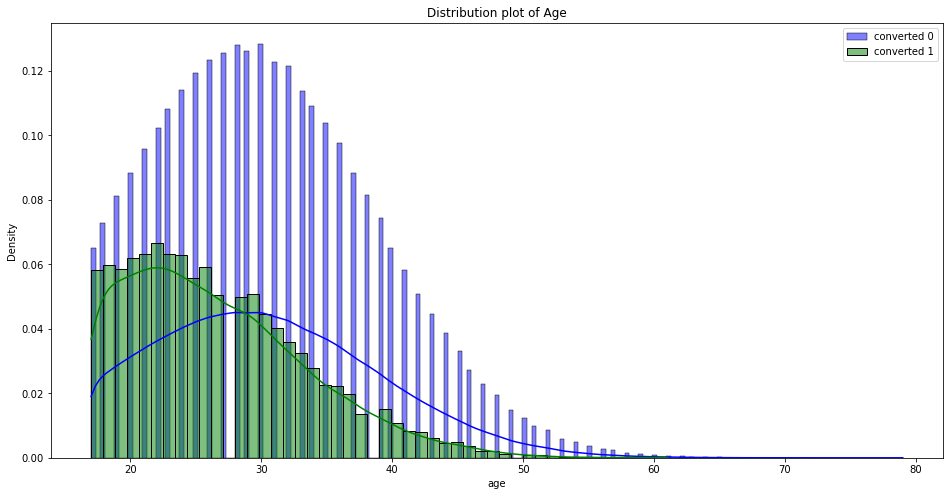

In [9]:
# plt.hist(df_conversion['age'], bins=5, edgecolor='black', alpha=0.7)
# hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

subset_data_0 = df_conversion[df_conversion['converted'] == 0]['age']
subset_data_1 = df_conversion[df_conversion['converted'] == 1]['age']
plt.figure(figsize=(16,8))
sns.histplot(subset_data_0, label='converted 0', kde=True,color='blue', stat='density')
sns.histplot(subset_data_1, label='converted 1', kde=True, color='green', stat='density')
plt.legend()
plt.title('Distribution plot of Age')


Text(0.5, 1.0, 'Source Conversion')

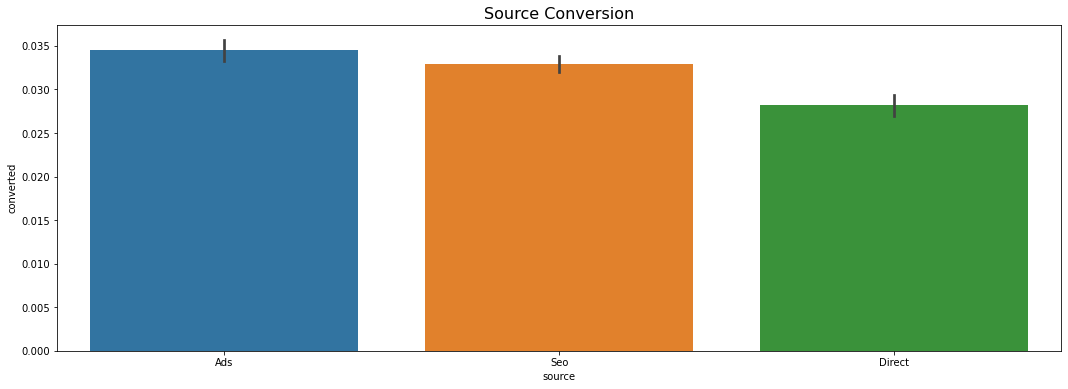

In [10]:
plt.figure(figsize=(18,6))
sns.barplot(x='source', y='converted', data=df_conversion)
plt.title('Source Conversion', fontsize=16)


### There is a direct correlation between page visited and conversion

In [31]:
plt.figure(figsize=(12,8))
mean_page = df_conversion.groupby('total_pages_visited')['converted'].mean().reset_index()
mean_page.head(2)

,total_pages_visited,converted
0,1,0.000000
1,2,0.000228


<Figure size 864x576 with 0 Axes>

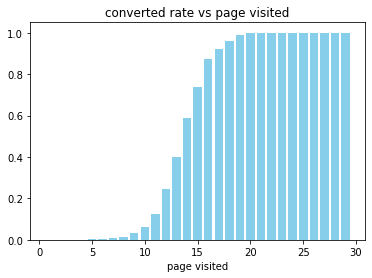

In [32]:
plt.bar(mean_page['total_pages_visited'], mean_page['converted'], color='skyblue')
plt.title('converted rate vs page visited')
plt.xlabel('page visited');

In [12]:
proportions = df_conversion.groupby('converted')['converted'].count() / df_conversion.groupby('converted')['converted'].count().sum()
proportions
# the dataset is not balanced, we want to use down sampling  

converted
0    0.967748
1    0.032252
Name: converted, dtype: float64

In [13]:
import pandas as pd

minority_class = df_conversion[df_conversion['converted'] == 1] 
majority_class = df_conversion[df_conversion['converted'] == 0]

minority_size = len(minority_class)

majority_downsampled = majority_class.sample(n=minority_size*3, random_state=42)  # Use a random seed for reproducibility

balanced_dataset = pd.concat([minority_class, majority_downsampled], axis=0)
proportions = balanced_dataset.groupby('converted')['converted'].count() / balanced_dataset.groupby('converted')['converted'].count().sum()
proportions

converted
0    0.75
1    0.25
Name: converted, dtype: float64

# Prediction model
- our goal is to predict conversion 

The outcome is binary, we have some choices such as 
- decision tree
- logistic classification

In [14]:
df_dummy = pd.get_dummies(balanced_dataset,columns=['source','country'], drop_first=True)
df_dummy

,age,new_user,total_pages_visited,converted,source_Direct,source_Seo,country_Germany,country_UK,country_US
54,25,1,18,1,1,0,0,0,1
72,33,0,15,1,0,1,0,0,1
87,18,0,19,1,1,0,0,0,1
130,17,0,19,1,0,0,0,0,1
182,19,0,9,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
300285,28,1,4,0,0,1,0,0,1
96293,40,1,3,0,0,0,0,1,0
232438,24,1,1,0,0,1,0,0,1
170499,26,0,5,0,0,0,0,0,1


In [15]:
import numpy as np 
y=df_dummy['converted']

X=df_dummy.drop(['converted'],axis=1)

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
x_train.head()

,age,new_user,total_pages_visited,source_Direct,source_Seo,country_Germany,country_UK,country_US
141038,26,1,4,1,0,0,1,0
140321,30,0,12,1,0,0,0,1
176107,40,0,6,1,0,0,0,1
104614,25,0,16,0,0,0,1,0
36384,33,0,1,0,1,0,0,1


In [18]:
x_train.shape, x_test.shape

((32633, 8), (8159, 8))

## random forest

In [19]:
from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn import tree


forest = RandomForestClassifier(criterion='gini', max_depth=3, random_state=20)  
forest.fit(x_train, y_train)


RandomForestClassifier(max_depth=3, random_state=20)

In [20]:
from sklearn.metrics import classification_report

y_pred = forest.predict(x_test)
y_pred_train = forest.predict(x_train)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6082
           1       0.93      0.83      0.88      2077

    accuracy                           0.94      8159
   macro avg       0.94      0.90      0.92      8159
weighted avg       0.94      0.94      0.94      8159



In [21]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm['Total'] = np.sum(cm, axis=1)
cm = cm.append(np.sum(cm, axis=0), ignore_index=True)
cm.columns = ['Predicted No', 'Predicted Yes', 'Total']
cm = cm.set_index([['Actual No', 'Actual Yes', 'Total']])

print(cm)

            Predicted No  Predicted Yes  Total
Actual No           5959            123   6082
Actual Yes           354           1723   2077
Total               6313           1846   8159


/var/folders/c9/gr5kq0l1683229k0zcc__0k80000gn/T/ipykernel_16891/1576294161.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cm = cm.append(np.sum(cm, axis=0), ignore_index=True)


### After balance dataset, the model perform much better 
- recall: Here we focus on recall more since recall emphasize FN: it is a lost of revenue if there is high possibility of watching a movie but we fail to detect it. We want high Recall. 
- precision: For precision is FP: if we offer ads but user does not watch, it is not a big lost
- Accuacy:
TP+TN/TP+TN+FP+FN 判断对的/所有判断, 5% chance of making mistake 

In [22]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Model accuracy score with criterion gini index: 0.9415
Training-set accuracy score: 0.9392


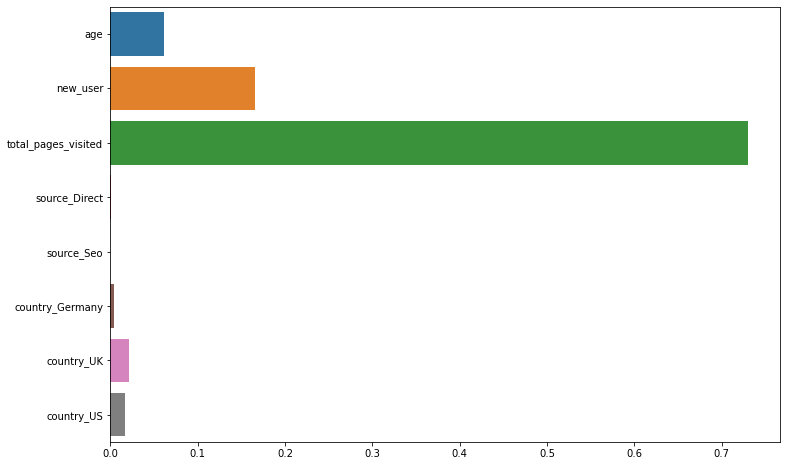

In [23]:
plt.figure(figsize=(12,8))
sns.barplot(x=forest.feature_importances_, y=X.columns);

total pages has the most importance, we can next take out this feature and do an anlysis on the others 

## deicison tree


In [24]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(max_depth=3,class_weight={0: 0.7, 1: 0.3})
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.7, 1: 0.3}, max_depth=3)

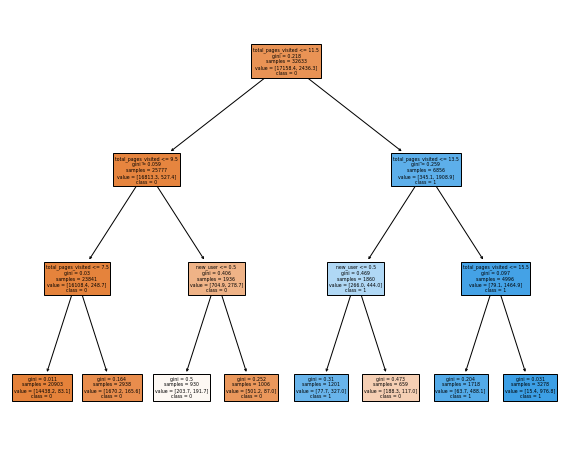

In [25]:


from sklearn import tree
plt.figure(figsize=(10, 8))
tree.plot_tree(dt, 
               feature_names=list(x_train.columns), 
               class_names=['0', '1'],  
               filled=True)
plt.show()


In [33]:
y_pred = dt.predict(x_test)
y_pred_train = dt.predict(x_train)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      6082
           1       0.97      0.74      0.84      2077

    accuracy                           0.93      8159
   macro avg       0.94      0.86      0.90      8159
weighted avg       0.93      0.93      0.92      8159



### From the decision tree, we learn total page visited is the most important feature that determine user's conversion rate. We shall increase our exposure digitally through ads or partnership to encourage people visit our page more. 

### The recall 0.74 should be improved. The model correctly identified 74% of all actual conversion instances.

## logistic regression

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


lg = LogisticRegression()
lg.fit(x_train, y_train)

intercept = lg.intercept_
coeff = lg.coef_
coef_list = list(coeff[0,:])
coef_df = pd.DataFrame({'Feature': list(x_train.columns),'Coefficient': coef_list})
print(coef_df)  

               Feature  Coefficient
0                  age    -0.070195
1             new_user    -1.717224
2  total_pages_visited     0.748392
3        source_Direct    -0.134696
4           source_Seo     0.069772
5      country_Germany     3.466320
6           country_UK     3.256028
7           country_US     2.977463


/Users/winniecai/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Given that users from Germany, the UK, and the US have significantly higher conversion rates, consider focusing marketing efforts on these countries. Tailor marketing campaigns and messaging to resonate with users from these regions. Besides, encourage users to visit more pages on our website. This can be achieved through improved site navigation, suggested content, or personalized recommendations. As the number of pages visited strongly correlates with higher conversion rates, increasing user engagement can have a positive impact.

In [27]:
y_pred = lg.predict(x_test)
y_pred_train = lg.predict(x_train)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6082
           1       0.93      0.88      0.90      2077

    accuracy                           0.95      8159
   macro avg       0.94      0.93      0.94      8159
weighted avg       0.95      0.95      0.95      8159



In [29]:
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Model accuracy score with criterion gini index: 0.9517
Training-set accuracy score: 0.9488


### logistic regression and decision tree kind of perform the same 

histogram
correlation matrix 
bias: more man or women 
normalize data 

goodness of fit 
model need to work cross different group of people 
cross validation 